In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
import bt_tools as bt

import importlib
importlib.reload(bt)

<module 'bt_tools' from '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/bt_tools.py'>

In [2]:
# data_pbe0 = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/all_energies.csv')
# data_pbe0 = data_pbe0.loc[(data_pbe0['Z1'] <= 9) & (data_pbe0['Z2'] <= 9)].to_dict('list')
# data_pbe0['unit'] = 630
# b_pbe0_nl = bt.BDE_clean.fromdict(data_pbe0)

data_W4_17 = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/W4-17.csv').to_dict('list')
data_W4_17['unit'] = 1
data_W4_17['nbfe'] = []
for Z1, Z2 in zip(data_W4_17['Z1'], data_W4_17['Z2']):
    data_W4_17['nbfe'].append(Z1*Z2*630)

b_nl = bt.BDE_clean.fromdict(data_W4_17)

In [3]:
# leave one out

def non_linear_model(var, a, b, c):
    Z1, Z2 = var.T
    ebfe = -a**2 - b**2*Z1*Z2 -c**2*(Z1**(7/3)+Z2**(7/3))
    return(ebfe)

def fit_leave_out(model, test_ind, ydata, xdata):

    # split in training/test
    num_samples = len(ydata)
    tr_indices = np.arange(num_samples)
    tr_indices = tr_indices[tr_indices != test_ind]

    # fit
    fit_out = curve_fit(model, xdata[tr_indices], ydata[tr_indices])
    coeffs = fit_out[0]
    
    # predict
    predictions = model(xdata, *coeffs)
    
    return(predictions)

In [4]:
bde_fit = dict()

for test_ind in range(10):
    ebfe_pred = fit_leave_out(non_linear_model, test_ind, b_nl.ebfe, b_nl.xdata)

    bde_pred = -(ebfe_pred + b_nl.nbfe)

    bde_fit[data_W4_17['smiles'][test_ind]] = bde_pred[test_ind]

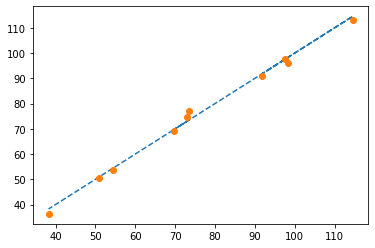

In [5]:
plt.plot(b_nl.bde, b_nl.bde, '--')
plt.plot(b_nl.bde,bde_fit.values(), 'o')

In [6]:
# uqm.save_obj(bde_fit, '/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/bde_nlSRL_l1o')